# AV Scheduling for household

### Initialize
* Inital functions and package
* Read input

In [43]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
from DYNASMART_Process import *
import DYNASMART_Process as dy
import AV_functions as av
from gurobipy import *
import datetime
import requests

In [45]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
#Trip mode
#1 Drive alone free; 2 Drive alone pay; 3 Shared ride 2 free; 4 Shared ride 2 pay ;
#5 Shared ride 3+ free; 6 Shared ride 3+ pay; 7 Walk; 8 Bike; 9 Walk to local transit; 
#10 Walk to premium transit; 11 Drive to local transit; 12 Drive to premium transit; 
#13 Taxi; 14 School bus

traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
#Calculate the expected trip travel time as trip start time of trip (i+1) - start time of trip i - activity time 
traveler_trips['Diff_bet_starttime']=traveler_trips.starttime.diff()[1:]
traveler_trips.Diff_bet_starttime=traveler_trips.Diff_bet_starttime.shift(-1)
traveler_trips['Diff_bet_starttime'].apply(lambda x: 0 if x<0 else x)
traveler_trips['travel_time']=traveler_trips.Diff_bet_starttime-traveler_trips.ActivityTime
traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips,'travel_time']=1440-(traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['starttime']+traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['ActivityTime'])
traveler_trips.orig_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
                                    ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
                                    inplace=True)
traveler_trips.dest_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
                                    ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
                                    inplace=True)
traveler_trips.loc[:,'person_type']=traveler_trips.person_id.apply(lambda x: person_type_dic[x])
value_latearr_penalty_per_min=pd.read_csv('input/LateArrPenalty.dat',sep='\t',index_col =0)
value_earlyarr_penalty_per_min=pd.read_csv('input/EarlyArrPenalty.dat',sep='\t',index_col =0)
early_penalty_threshold=pd.read_csv('input/EarlyArrPenaltyThreshold.dat',sep='\t',index_col=0)
late_penalty_threshold=pd.read_csv('input/LateArrPenaltyThreshold.dat',sep='\t',index_col=0)

traveler_trips.loc[:,'earlyarr_penalty']=traveler_trips.apply(lambda row: value_earlyarr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
traveler_trips.loc[:,'latearr_penalty']=traveler_trips.apply(lambda row: value_latearr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
traveler_trips.loc[:,'early_penalty_threshold']=traveler_trips.apply(lambda row: early_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
traveler_trips.loc[:,'late_penalty_threshold']=traveler_trips.apply(lambda row: late_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')

### Basic Statistics

In [47]:
traveler_trips.head()

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,...,hh_id,origin_node,destination_node,Diff_bet_starttime,travel_time,person_type,earlyarr_penalty,latearr_penalty,early_penalty_threshold,late_penalty_threshold
0,8600957,11,0.1164,1,24.0,1,Home,Shop,1,1,...,2744264,9737,10716,30.0,6.0,Part-time-worker,0.01,0.01,60.0,60.0
1,8600957,11,0.1164,2,32.0,3,Shop,EatingOut,62,16,...,2744264,10716,10057,37.0,5.0,Part-time-worker,0.01,0.01,60.0,60.0
2,8600957,11,0.1164,3,39.0,1,EatingOut,Maintenance,20,5,...,2744264,10021,9674,41.0,2.0,Part-time-worker,0.01,0.01,60.0,60.0
3,8600957,11,0.1164,4,198.0,3,Maintenance,Home,3,1,...,2744264,9737,9675,199.0,1.0,Part-time-worker,0.00,0.02,120.0,30.0
4,8600957,11,0.1164,5,191.0,1,Home,Work,1,1,...,2744264,9673,9736,192.0,1.0,Part-time-worker,0.20,0.50,30.0,15.0


In [49]:
traveler_trips.columns

Index(['person_id', 'num_trips', 'value_of_time', 'trip_counter',
       'ActivityTime', 'tripmode', 'orig_purpose', 'dest_purpose', 'orig_maz',
       'orig_taz', 'dest_maz', 'dest_taz', 'driver_passenger_flag',
       'joint_trip_flag', 'park&ride_flag', 'starttimeinterval', 'starttime',
       'hh_id', 'origin_node', 'destination_node', 'Diff_bet_starttime',
       'travel_time', 'person_type', 'earlyarr_penalty', 'latearr_penalty',
       'early_penalty_threshold', 'late_penalty_threshold'],
      dtype='object')

In [51]:
#Num of household
print('Number of household: \t',len(traveler_trips.hh_id.unique()))
print('Number of traveler: \t',len(traveler_trips.person_id.unique()))
print('Number of trips: \t',len(traveler_trips))
print('Number of indiv trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==0]))
print('Number of joint trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==1]))

Number of household: 	 32472
Number of traveler: 	 76499
Number of trips: 	 382158
Number of indiv trip: 	 333264
Number of joint trip: 	 48894


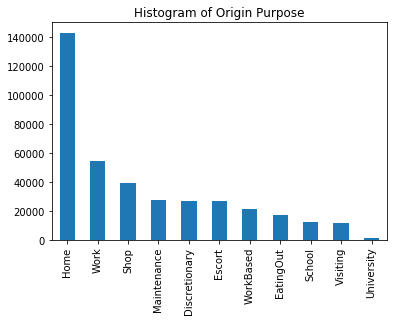

In [53]:
traveler_trips['orig_purpose'].value_counts().plot(kind='bar',title='Histogram of Origin Purpose')

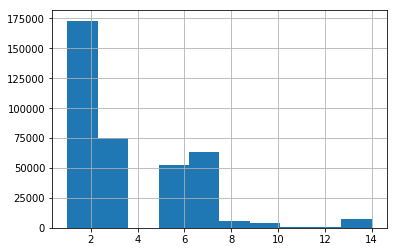

In [55]:
traveler_trips.tripmode.hist()

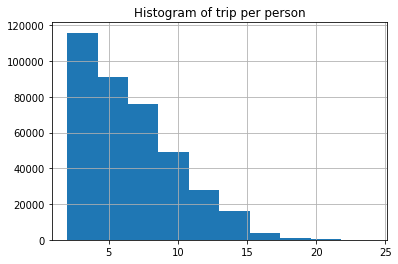

In [57]:
traveler_trips.num_trips.hist()
plt.pyplot.title('Histogram of trip per person')

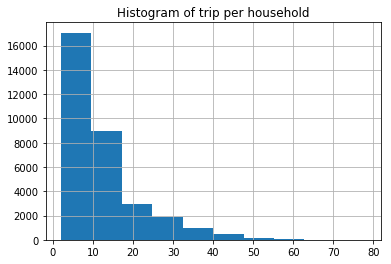

In [59]:
traveler_trips.groupby('hh_id')['num_trips'].count().hist()
plt.pyplot.title('Histogram of trip per household')

In [61]:
def identify_indiv_trip_before_jointtrip(traveler_trips):
    before_joint_trip=pd.DataFrame()
    for traveler in traveler_trips.person_id.unique():
#         print(traveler,len(traveler_trips[traveler_trips.person_id==traveler])-1)
        for index in range(len(traveler_trips[traveler_trips.person_id==traveler])-1):
#             if(traveler==5982639):
#                 print(traveler,index,(traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index]['joint_trip_flag']==0),(traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index+1]['joint_trip_flag']==1)) 
            if (traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index]['joint_trip_flag']==0) & (traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index+1]['joint_trip_flag']==1):  
#                 print(traveler,index)
                before_joint_trip=before_joint_trip.append(traveler_trips[traveler_trips.person_id==traveler].iloc[index])
    check_joint_trip=traveler_trips.loc[(traveler_trips['joint_trip_flag']==1) & (traveler_trips.trip_counter>2)]
    
#     if (len(check_joint_trip)/2 != len(before_joint_trip)):
#         print(traveler_trips.hh_id.unique(),len(check_joint_trip)/2, len(before_joint_trip))
    return before_joint_trip

In [63]:
# num_ind_trip=[]
# for hh in traveler_trips.hh_id.unique():
#     target_hh=traveler_trips[traveler_trips.hh_id==hh]
#     num_ind_trip.extend([len(identify_indiv_trip_before_jointtrip(target_hh))])

### Draw the sub-area network

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hol

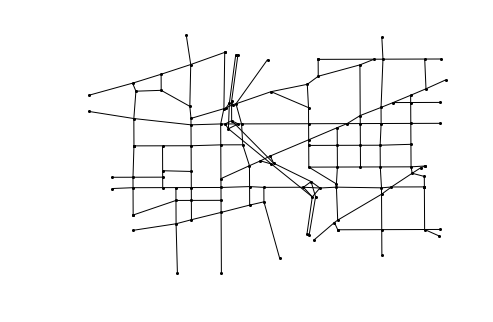

In [65]:
cluster_highlight([])

### Sample Household
Select household 2105189 for intial analysis

10


C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hol

9
4
7


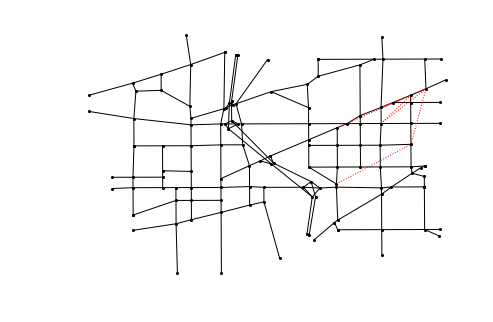

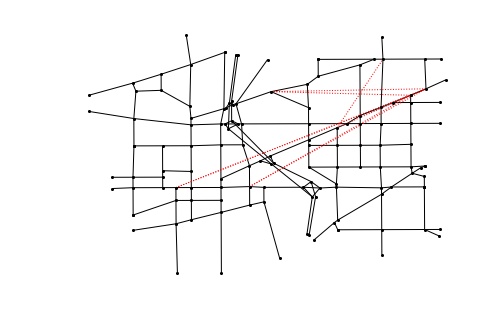

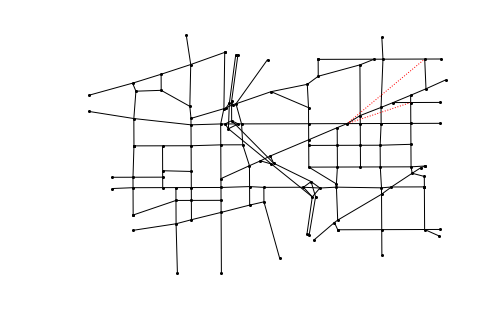

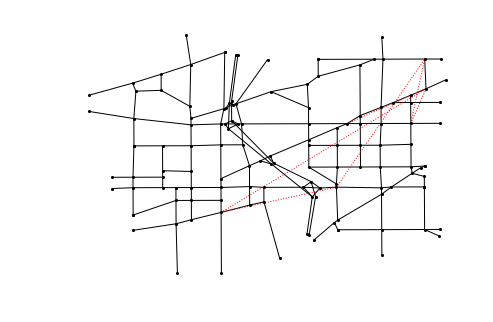

In [67]:
target_hh_id=2105189
people_in_hh=traveler_trips[traveler_trips['hh_id']==2105189]['person_id'].unique()
for person in people_in_hh:
    #creat trip-chain-origin-destination-list
    num_trips=traveler_trips[traveler_trips['person_id']==person]['num_trips'].iloc[0]
    print(num_trips)
    trip_chain_or=traveler_trips[traveler_trips['person_id']==person][['origin_node','destination_node']]
    trip_chain_or['origin_node'].iloc[1:num_trips-1]=trip_chain_or['destination_node'].iloc[0:num_trips-2].tolist()
    trip_chain_or['origin_node'].iloc[num_trips-1]=trip_chain_or['destination_node'].iloc[num_trips-2]
    #draw the graph
    av.trip_chain_highlight(trip_chain_or,node_detail,link_detail,nodexy)
#traveler_trips[traveler_trips['hh_id']==2105189]

In [69]:
target_hh=traveler_trips[traveler_trips['hh_id']==2105189]

### Solve the optimization for a household 

The factors need to know about:  
1. Decision variable X <sub>ij</sub> and T<sub>j</sub> (departure time from node j)  
2. R <sub>i</sub> reward of visiting node i
3. S <sub>i</sub> penalty for late/early arrival
4. C <sub>ij</sub> travel time between node i and j  
5. 

In [71]:
# target_hh_id=2105189
# hh_members=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
# # hh_num_trips=traveler_trips[traveler_trips['hh_id']==target_hh_id]['num_trips'].value_counts().sum()
# num_hh_member=hh_members.size

# target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
# sorted_trips=target_hh.sort_values("starttime")
# hh_num_trips=sorted_trips.shape[0]
# sorted_trips["hh_index"]=(range(hh_num_trips))
# R=np.ones(hh_num_trips+1)*15
# #Calculate the distance matrix between all node pairs
# np.random.seed(1)
# C=np.random.rand(2*hh_num_trips+2,2*hh_num_trips+2)*10
# visit_candidate=[sorted_trips['origin_node'].iloc[0]]
# visit_candidate.extend(sorted_trips['origin_node'].tolist())
# visit_candidate.extend(sorted_trips['destination_node'].tolist())
# visit_candidate.extend([sorted_trips['origin_node'].iloc[0]])
# # C= av.calculate_node_distance_matrix(visit_candidate,nodexy,C)
# c=av.calculate_node_travel_time_matrix(visit_candidate,nodexy)

#### Solve with heuristic

In [73]:
# #Solve with heuristic
# ############################
# #Construct initial feasible solution
# def initial_solution(sorted_trips,hh_num_trips,num_hh_member,C,visit_candidate):
#     #First start with the earlist trip and add the next trip whenever possible
#     #########################
#     #Sort all household trips by time
#     trip_list=[]
#     last_start_time=0
#     last_dest_index=0
#     last_travel_time=0 #The travel time between the OD of same trip
#     trip_list=[]
#     index=0
#     for index1,trip in sorted_trips.iterrows():
#         #If it does not violate the time constraint then add the trip to the route
#         current_travel_time=C[last_dest_index,index+1] #The travel time between the orig of #current trip and the dest of last trip
#         print(trip['starttime'],'\t',index+1,'\t',last_dest_index,'\t',last_travel_time,'\t',last_start_time,'\t',current_travel_time)
#         if trip['starttime']>last_travel_time+last_start_time+current_travel_time:
#             trip_list.extend([trip['hh_index']])
#             last_start_time=trip['starttime']
#             last_dest_index=index+1+hh_num_trips
#             last_travel_time=C[index+1,index+1+hh_num_trips]
#             print(last_dest_index,index+1,trip['hh_index'])
#         index+=1
#     return trip_list

In [75]:
# i=0
# num_optimization=0
# num_conflict_trips={}
# last_time=datetime.datetime.now()
# for target_hh_id in [2105189]: #traveler_trips['hh_id'].unique():
# #     hh_members=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
#     # hh_num_trips=traveler_trips[traveler_trips['hh_id']==target_hh_id]['num_trips'].value_counts().sum()
#     num_hh_member=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique().size
#     target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
#     sorted_trips=target_hh.sort_values("starttime")
#     hh_num_trips=sorted_trips.shape[0]
#     sorted_trips["hh_index"]=(range(hh_num_trips))
#     C=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
#     visit_candidate=[sorted_trips['origin_node'].iloc[0]]
#     visit_candidate.extend(sorted_trips['origin_node'].tolist())
#     visit_candidate.extend(sorted_trips['destination_node'].tolist())
#     visit_candidate.extend([sorted_trips['origin_node'].iloc[0]])
#     C= av.calculate_node_distance_matrix(visit_candidate,nodexy,C)*1.5*5
# #     C=av.calculate_node_travel_time_matrix(visit_candidate,nodexy)
#     route=initial_solution(sorted_trips,hh_num_trips,num_hh_member,C,visit_candidate)
#     i=i+1
#     if len(route)!=hh_num_trips:
#         num_optimization=num_optimization+1
#         if (hh_num_trips-len(route)) in num_conflict_trips:
#             num_conflict_trips[hh_num_trips-len(route)]=num_conflict_trips[hh_num_trips-len(route)]+1
#         else:
#             num_conflict_trips[hh_num_trips-len(route)]=1
#     if (i%1000==0):
#         print(i,target_hh_id,num_optimization,datetime.datetime.now()-last_time)
# #         last_time=datetime.datetime.now()

## Estimate travel time and cost

### Estimate vehicular travel time and cost from skim file (result from previous run)

In [77]:
def read_vehicle_skim(skim_folder_path):
    '''
    This function reads in the skim file information and store them in a multiindex dataframe Vehicular_Skim
    '''
    Max_Num_Vot=5
    # Get the basic parameters for reading the vehicle skim
    NumSkimSuperZone=len(os.listdir(skim_folder_path))
    with open(skim_folder_path+'/1.dat') as f: 
        for line,i in zip(f,range(3)):
            if i==0 and 'TAZ' in line: 
                NumIteration=1
                NumSkimOriginZone=line.split()[0]
            elif i==0 and 'NTI' in line: 
                NumIteration=0
                NumSkimIntervals=line.split()[0]
            elif i==1 and 'NTI' in line: 
                NumSkimIntervals=line.split()[0]
            elif i==1 and 'TAZ' in line:
                NumSkimOriginZone=line.split()[0]
    NumSkimIntervals=int(NumSkimIntervals)
    NumSkimOriginZone=int(NumSkimOriginZone)
    print(NumSkimSuperZone,NumSkimOriginZone,NumSkimIntervals)
    #Create a list of Time and Origin. The list is determined by how the data were writen in the vehicularpnrskim
    #When interation equals 0, the file iterate through time frist. In other words the loop should be writen as 
    #(do O=1,NumSkimOriginZone: do T=1, NumSkimIntervals). When iteration number is lager than 1, the order reverse
    if NumIteration>0:
        Tlist=list(range(1,NumSkimIntervals+1))*NumSkimOriginZone
        Olist=list(np.repeat(range(1,NumSkimOriginZone+1),NumSkimIntervals))
    else:
        Tlist=list(np.repeat(range(1,NumSkimIntervals+1),NumSkimOriginZone))
        Olist=list(range(1,NumSkimOriginZone+1))*NumSkimIntervals
    #Start to read the files 
    Os=[]
    Ds=[]
    Ts=[]
    VotNo=[]
    VotValue=[]
    Cost=[]
    Time=[]
    Dist=[]
    for D in range(1,NumSkimSuperZone+1): #D is the destination 
        print('read',D,datetime.datetime.now())
        with open(skim_folder_path+'/'+str(D)+'.dat') as f: 
            for _ in range(2):
                next(f)
            for line,O,T in zip(f,Olist,Tlist): 
                line_list=line.split()
                Num_VOT=int(line_list[0])
                for j in range(1,Num_VOT+1): 
                    Os.extend([int(O)])
                    Ds.extend([int(D)])
                    Ts.extend([int(T)])
                    VotNo.extend([j])
                    VotValue.extend([float(line_list[4*j-3])])
                    Cost.extend([float(line_list[4*j-2])])
                    Time.extend([float(line_list[4*j-1])])
                    Dist.extend([float(line_list[4*j])])
    Vehicular_Skim=pd.DataFrame(data={'O':Os,'D':Ds,'T':Ts,'VotIndex':VotNo,'Vot':VotValue
                                     ,'Cost':Cost,'Time':Time,'Dist':Dist})          
    Vehicular_Skim.set_index(['O', 'D','T','VotIndex'], inplace=True)
    Vehicular_Skim.sort_index(inplace=True)
    return Vehicular_Skim

In [79]:
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim=read_vehicle_skim(VPNRSkim_folder_filepath)

56 57 144
read 1 2018-03-05 22:57:18.251549
read 2 2018-03-05 22:57:18.329672
read 3 2018-03-05 22:57:18.392172
read 4 2018-03-05 22:57:18.470298
read 5 2018-03-05 22:57:18.553422
read 6 2018-03-05 22:57:18.647168
read 7 2018-03-05 22:57:18.750726
read 8 2018-03-05 22:57:18.844470
read 9 2018-03-05 22:57:18.906970
read 10 2018-03-05 22:57:19.002573
read 11 2018-03-05 22:57:19.091641
read 12 2018-03-05 22:57:19.169767
read 13 2018-03-05 22:57:19.290139
read 14 2018-03-05 22:57:19.399508
read 15 2018-03-05 22:57:19.477640
read 16 2018-03-05 22:57:19.549261
read 17 2018-03-05 22:57:19.627391
read 18 2018-03-05 22:57:19.705513
read 19 2018-03-05 22:57:19.776270
read 20 2018-03-05 22:57:19.854389
read 21 2018-03-05 22:57:19.948223
read 22 2018-03-05 22:57:20.018599
read 23 2018-03-05 22:57:20.127974
read 24 2018-03-05 22:57:20.197521
read 25 2018-03-05 22:57:20.275650
read 26 2018-03-05 22:57:20.353773
read 27 2018-03-05 22:57:20.428411
read 28 2018-03-05 22:57:20.522158
read 29 2018-03-05 

In [81]:
def read_transit_setting(transit_setting_filepath):
    f=open(transit_setting_filepath,'r')
    TransitMazTazFlag=int(next(f).split()[0])
    drivingweight=float(next(f).split()[0])
    walkingweight=float(next(f).split()[0])
    TransitSkimTimeIntervalLength=float(next(f).split()[0])
    MaxNumTransitSkimTimeInterval=int(int(next(f).split()[0]))
    WalkSpeed=float(next(f).split()[0])
    return TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed
def read_pnr_zones(three_link_pnr):
    '''
    This function is called by function read_transitskim
    This function return the transit_zone_candidates where the first column is the zones in the 
    DYNSMART network and the second column is the transit zone in the three-link zone, which is
    indicated by the first column
    '''
    from collections import defaultdict
    transit_zone_candidates=defaultdict(list)
    for line in three_link_pnr:
        if 'tran' not in line:
            transit_zone_candidates[int(line.split()[0])].extend([int(line.split()[1])])
    return transit_zone_candidates
def read_threelink_walk(three_link_walk_file):
    three_link_walk_list=[]
    for line in three_link_walk_file:
        if 'tran' not in line: 
            three_link_walk_list.append([float(i) for i in line.split()])
    
    three_link_walk=pd.DataFrame(data=three_link_walk_list,columns=['three_link_zone','transit_zone','distance'])
    return three_link_walk
def read_transitskim(transit_skim_folderpath):
    '''
    This function call the read_transit_setting function and read_pnr_zones function
    This function returns all the NUTRANS realated parameters such as:TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed
    This function returns the transit zone associated with each DYNSAMART zone in transit_zone_candidates
    This function also returns the transit AB cost skim which is the estimated travel time between zones at each time interval
    
    '''
    #First read the transit setting file
    transit_setting_filepath=transit_skim_folderpath+'TransitSetting.dat'
    TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed=read_transit_setting(transit_setting_filepath)
    #Next depends on the setting file determine whether the file is maz based or taz based
    ab_time_f=open(transit_skim_folderpath+'TransitPNRSkim_AB_time.dat','r')
    if TransitMazTazFlag==0:
        ab_cost_f=open(transit_skim_folderpath+'TransitPNRSkim_AB_cost.dat','r')
        ba_time_f=open(transit_skim_folderpath+'TransitPNRSkim_BA_time.dat','r')
        ba_cost_f=open(transit_skim_folderpath+'TransitPNRSkim_BA_cost.dat','r')
        three_link_pnr=open(transit_skim_folderpath+'input_threelink_PNR.dat','r')
        three_link_walk_file=open(transit_skim_folderpath+'input_threelink_walk.dat','r')
    else:
        ab_cost_f=open(transit_skim_folderpath+'TransitPNRSkim_AB_cost_TAZ.dat','r')
        ba_time_f=open(transit_skim_folderpath+'TransitPNRSkim_BA_time_TAZ.dat','r')
        ba_cost_f=open(transit_skim_folderpath+'TransitPNRSkim_BA_cost_TAZ.dat','r')
        three_link_pnr=open(transit_skim_folderpath+'input_threelink_PNR_TAZ.dat','r')
        three_link_walk_file=open(transit_skim_folderpath+'input_threelink_walk_TAZ.dat','r')
    transit_zone_candidates=read_pnr_zones(three_link_pnr)
    three_link_walk=read_threelink_walk(three_link_walk_file)
    cost_temp=[]
    for line in ab_cost_f:
        cost_temp.append([float(i) for i in line.split()])
    time_temp=[]
    for line in ab_time_f:
        time_temp.append([float(i) for i in line.split()])
    column_name=['otap','dtap']
    column_name.extend([i for i in range(MaxNumTransitSkimTimeInterval)])
    Transit_AB_Cost_Skim=pd.DataFrame(data=cost_temp,columns=column_name)
    Transit_AB_Time_Skim=pd.DataFrame(data=time_temp,columns=column_name)
    return TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk

In [83]:
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=read_transitskim(transit_skim_folderpath)

In [85]:
Transit_AB_Cost_Skim.head()

,otap,dtap,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,24.0,1440.0,1440.0,1440.0,1440.0,34.0,34.0,19.5,19.5,...,1440.0,1440.0,1440.0,1440.0,1440.0,35.0,1440.0,1440.0,1440.0,1440.0
2,4.0,34.0,1440.0,1440.0,1440.0,1440.0,34.0,34.0,19.5,19.5,...,1440.0,1440.0,1440.0,1440.0,1440.0,35.0,1440.0,1440.0,1440.0,1440.0
3,4.0,36.0,1440.0,1440.0,1440.0,1440.0,109.7,82.4,83.4,110.7,...,1440.0,1440.0,1440.0,1440.0,1440.0,111.7,1440.0,1440.0,1440.0,1440.0
4,4.0,37.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,...,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0


In [87]:
three_link_walk.head()

,three_link_zone,transit_zone,distance
0,1.0,4.0,4702.091222
1,1.0,24.0,18806.588630
2,1.0,37.0,18982.033670
3,1.0,65.0,21330.843820
4,1.0,39.0,21422.376550


### Derive travel time from Google api

In [89]:
# #Derive the travel time matrix from google api
# origin_node=[]
# destination_node=[]
# travel_time=[]
# k=0
# for i in nodexy:
#     print(k)
#     k=k+1
#     for j in nodexy:
#         origin_node.extend([i])
#         destination_node.extend([j])
#         travel_time.extend([travel_time_between_nodes(int(i),int(j),nodexy)])

## Solve the optimization with Gurobi

In [258]:
def get_travel_cost_matrix(sorted_trips,Vehicular_Skim,superzone_map):
    '''
    This function returns two matrix: 
    C: the cost matrix
    TT: the travel time matrix
    '''
    
    num_skim_interval=Vehicular_Skim.index.get_level_values('T').max()
    
    hh_num_trips=sorted_trips.shape[0]
    C=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
    TT=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
    visit_candidate_zone=[sorted_trips['orig_taz'].iloc[0]]
    visit_candidate_zone.extend(sorted_trips['orig_taz'].tolist())
    visit_candidate_zone.extend(sorted_trips['dest_taz'].tolist())
    visit_candidate_zone.extend([sorted_trips['orig_taz'].iloc[0]])
#     midday_timeinterval=len(Vehicular_Skim.index.get_level_values('T').unique())*5/24

    correlated_skim_time_interval=[math.ceil(sorted_trips.starttime.iloc[0].item()/num_skim_interval)]
    correlated_skim_time_interval.extend(sorted_trips.starttime.apply(lambda x: math.ceil(x/num_skim_interval)))
    correlated_skim_time_interval.extend(sorted_trips.starttime.apply(lambda x: math.ceil(x/num_skim_interval)))
    correlated_skim_time_interval.extend([math.ceil(sorted_trips.starttime.iloc[-1].item()/num_skim_interval)])
    correlated_vot=[0.16]
    correlated_vot.extend(sorted_trips.value_of_time)
    correlated_vot.extend([0.16]*(hh_num_trips+1))
    for i,ozone in zip(range(len(visit_candidate_zone)),visit_candidate_zone):
        for j,dzone in zip(range(len(visit_candidate_zone)),visit_candidate_zone):
            if i!=j:
                time_temp=Vehicular_Skim.loc[ozone,superzone_map[dzone],correlated_skim_time_interval[i],1]['Time'].item()
                cost_temp=Vehicular_Skim.loc[ozone,superzone_map[dzone],correlated_skim_time_interval[i],1]['Cost'].item()
                C[i,j]=time_temp*correlated_vot[i]+cost_temp
                TT[i,j]=time_temp
#                 C[i,j]=Vehicular_Skim.loc[ozone,superzone_map[dzone],72,1]['Time'].item()
                if j==i-hh_num_trips+1 and i <2*hh_num_trips:
                    print(i-hh_num_trips-1,j-1)
                    print(sorted_trips.iloc[i-hh_num_trips-1].person_id )
                    print(sorted_trips.iloc[j-1].person_id)
                    if (sorted_trips.iloc[i-hh_num_trips-1].person_id == sorted_trips.iloc[j-1].person_id):
                        C[i,j]=0
                        TT[i,j]=0
            else:   
                C[i,j]=0
                TT[i,j]=0
#             if i>0 and j ==i+hh_num_trips:
#                 print(sorted_trips['travel_time'].iloc[i-1])
#                 print('check')
#                 print(Vehicular_Skim.loc[ozone,dzone,72,1]['Time'])
    C[0,:]=0.01
    TT[0,:]=0.01
    C[:,2*hh_num_trips+1]=0.01
    TT[:,2*hh_num_trips+1]=0.01
#     for i in range(hh_num_trips): 
#         TT[i+1,i+hh_num_trips+1]=sorted_trips['travel_time'].iloc[i]
    return C,TT

In [255]:
hh_num_trips

64

In [251]:
len(visit_candidate_zone)

130

In [93]:
def estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk):
    if TransitMazTazFlag==0:
        orig_column_name='orig_maz'
        dest_column_name='dest_maz'
    else: 
        orig_column_name='orig_taz'
        dest_column_name='dest_taz'
    R=[150]
    for index,row in sorted_trips.iterrows():
        min_transit_time=1440
        transit_time_temp=1440
        transit_start_time_interval=math.ceil(row.starttime/TransitSkimTimeIntervalLength)-1
        for otap in three_link_walk.loc[three_link_walk.three_link_zone==row[orig_column_name]].transit_zone:
            for dtap in three_link_walk.loc[three_link_walk.three_link_zone==row[dest_column_name]].transit_zone:
                if Transit_AB_Cost_Skim.loc[(Transit_AB_Cost_Skim.otap==otap) & 
                                            (Transit_AB_Cost_Skim.dtap==dtap)].empty:
                    transit_time_temp=1440
                else:
                    transit_time_temp=Transit_AB_Cost_Skim.loc[(Transit_AB_Cost_Skim.otap==otap) 
                                                               &(Transit_AB_Cost_Skim.dtap==dtap)
                                                              ,int(transit_start_time_interval)].item()
                    if transit_time_temp==0:
                        transit_time_temp=1440
                if (transit_time_temp<min_transit_time):
                    min_transit_time=transit_time_temp
                    otap_candidate=otap
                    dtap_candidate=dtap
        R.extend([min_transit_time])
    return R


In [95]:
def estimate_single_transit_trip_cost(origin_zone,dest_zone,trip_start_time,TransitMazTazFlag,three_link_walk,Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength):
    min_transit_time=1440
    transit_time_temp=1440
    transit_start_time_interval=math.ceil(trip_start_time/TransitSkimTimeIntervalLength)-1
    for otap in three_link_walk.loc[three_link_walk.three_link_zone==origin_zone].transit_zone:
        for dtap in three_link_walk.loc[three_link_walk.three_link_zone==dest_zone].transit_zone:
            if Transit_AB_Cost_Skim.loc[(Transit_AB_Cost_Skim.otap==otap) & 
                                        (Transit_AB_Cost_Skim.dtap==dtap)].empty:
                transit_time_temp=1440
            else:
                transit_time_temp=Transit_AB_Cost_Skim.loc[(Transit_AB_Cost_Skim.otap==otap) 
                                                           &(Transit_AB_Cost_Skim.dtap==dtap)
                                                          ,int(transit_start_time_interval)].item()
                if transit_time_temp==0:
                    transit_time_temp=1440
            if (transit_time_temp<min_transit_time):
                min_transit_time=transit_time_temp
                otap_candidate=otap
                dtap_candidate=dtap
    return min_transit_time

In [97]:
def estimate_single_car_trip_cost(origin_zone,dest_zone,trip_start_time,vot,Vehicular_Skim):
    num_skim_interval=Vehicular_Skim.index.get_level_values('T').max()
    correlated_skim_time_interval=math.ceil(trip_start_time/num_skim_interval)
    time_temp=Vehicular_Skim.loc[origin_zone,superzone_map[dest_zone],correlated_skim_time_interval,1]['Time'].item()
    cost_temp=Vehicular_Skim.loc[origin_zone,superzone_map[dest_zone],correlated_skim_time_interval,1]['Cost'].item()
    car_trip_cost=time_temp*vot+cost_temp
    return car_trip_cost

In [99]:
# origin_trips_test=traveler_trips[traveler_trips.hh_id.isin(route_infos_full_adoption.hh_id.unique())].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
# mode_list=[]
# for index,row in origin_trips_test.iterrows():
#     transit_cost=estimate_single_transit_trip_cost(row.orig_maz,row.dest_maz,row.starttime,TransitMazTazFlag,three_link_walk,Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
#     car_cost=estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim)
#     print(transit_cost)
#     if transit_cost>car_cost:
#         mode_list.extend([0])
#     else:
#         mode_list.extend([1])

In [101]:
# def warm_start_with_heuristics(x,T,S,num_hh_member,hh_num_trips,TT,sorted_trips,expected_arrival_time):
#     x[0,1].start=1
#     x[1,1+hh_num_trips].start=0
#     last_node=1+hh_num_trips
#     for i in range(2*hh_num_trips+2):
#         T[i].start=expected_arrival_time[i]
#         S[i].start=0
#     for i in range(2,1+hh_num_trips):
#         if expected_arrival_time[last_node]+TT[last_node,i]<expected_arrival_time[i]:
#             x[last_node,i].start=1
#             x[i,i+hh_num_trips].start=1
#             last_node=i+hh_num_trips
#         else: 
#             x[last_node,i].start=0
#             x[i,i+hh_num_trips].start=0
#     return x,T,S
# x=warm_start_with_heuristics(x,T,S,num_hh_member,hh_num_trips,TT,sorted_trips,expected_arrival_time)

In [103]:
def estimate_num_vehicle_household(sorted_trips,method_flag):
    '''
    This function estimate the minimum number of AVs needed for a household
    method_flag=0: use av for all trips
    method_flag=1: use av only for trips previously conducted by car
    method_flag=2: use conventional vehicles for all trips
    method_flag=3: use conventional vehicles only for car trips 
    '''
    min_vector=np.zeros(1440)
    if method_flag==0: 
        for i, row in sorted_trips.iterrows():
            min_vector[int(row.starttime-1):int(row.starttime-1+row.travel_time)]+=1
    elif method_flag==1:
        for i, row in sorted_trips.loc[sorted_trips.tripmode<=6].iterrows():
            min_vector[int(row.starttime-1):int(row.starttime-1+row.travel_time)]+=1
    elif method_flag==2:
        for person in sorted_trips.person_id.unique():
            for index, row in sorted_trips.loc[sorted_trips.person_id==person].iterrows():
                if row.orig_purpose=='Home':
                    start_temp=row.starttime-1
                elif row.dest_purpose=='Home':
                    end_temp=row.starttime+row.travel_time-1
                    min_vector[int(start_temp):int(end_temp)]+=1
    elif method_flag==3:
        for person in sorted_trips.person_id.unique():
                for index, row in sorted_trips.loc[(sorted_trips.person_id==person) & (sorted_trips.tripmode<=6)].iterrows():
                    if row.orig_purpose=='Home':
                        start_temp=row.starttime-1
                    elif row.dest_purpose=='Home':
                        end_temp=row.starttime+row.travel_time-1
                        min_vector[int(start_temp):int(end_temp)]+=1
    
    return max(min_vector)

In [116]:
def extract_hh_information(target_hh_id,traveler_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map):
    '''
    Get the household related information. Those information will be used as input
    for the optimization model
    '''
    target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
    num_hh_member=target_hh['person_id'].unique().size
    #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
    sorted_trips=target_hh.sort_values("starttime")
    hh_num_trips=sorted_trips.shape[0]
    #hh_index give an index to all trips within the household for tracking purpose
    sorted_trips["hh_index"]=(range(hh_num_trips))
    
    #Then only keep the 
#     sorted_trips=sorted_trips.drop_duplicates(['orig_purpose','dest_purpose','orig_maz','dest_maz','starttime'],keep='first')
#     C=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
    visit_candidate=[sorted_trips['origin_node'].iloc[0]]
    visit_candidate.extend(sorted_trips['origin_node'].tolist())
    visit_candidate.extend(sorted_trips['destination_node'].tolist())
    visit_candidate.extend([sorted_trips['destination_node'].iloc[-1]])

    C,TT=get_travel_cost_matrix(sorted_trips,Vehicular_Skim,superzone_map)
    visit_candidate_zone=[sorted_trips['orig_taz'].iloc[0]]
    visit_candidate_zone.extend(sorted_trips['orig_taz'].tolist())
    visit_candidate_zone.extend(sorted_trips['dest_taz'].tolist())
    visit_candidate_zone.extend([sorted_trips['orig_taz'].iloc[0]])
    
    expected_arrival_time=np.ones(2*hh_num_trips+2)
    expected_arrival_time[0]=traveler_trips[traveler_trips['hh_id']==target_hh_id]['starttime'].min()-1
    expected_arrival_time[1:hh_num_trips+1]=sorted_trips.starttime
    expected_leave_time=np.ones(2*hh_num_trips+2)
    expected_leave_time[0:hh_num_trips+1]=expected_arrival_time[0:hh_num_trips+1]
    #Update the early/late penalty for each trip
    early_penalty=100*np.ones(2*hh_num_trips+2)
    late_penalty=100*np.ones(2*hh_num_trips+2)
    early_penalty[1:hh_num_trips+1]=sorted_trips.earlyarr_penalty
    late_penalty[1:hh_num_trips+1]=sorted_trips.latearr_penalty
    early_penalty[hh_num_trips+1:2*hh_num_trips+1]=sorted_trips.earlyarr_penalty
    late_penalty[hh_num_trips+1:2*hh_num_trips+1]=sorted_trips.latearr_penalty
    
    #Update the earl/late penalty threshold
    early_penalty_threshold=100*np.ones(2*hh_num_trips+2)
    late_penalty_threshold=100*np.ones(2*hh_num_trips+2)
    early_penalty_threshold[1:hh_num_trips+1]=sorted_trips.early_penalty_threshold
    late_penalty_threshold[1:hh_num_trips+1]=sorted_trips.late_penalty_threshold
    early_penalty_threshold[hh_num_trips+1:2*hh_num_trips+1]=sorted_trips.early_penalty_threshold
    late_penalty_threshold[hh_num_trips+1:2*hh_num_trips+1]=sorted_trips.late_penalty_threshold
    for i in range(1+hh_num_trips,2*hh_num_trips+1):
        expected_arrival_time[i]=expected_arrival_time[i-hh_num_trips]+TT[i-hh_num_trips,i]
        expected_leave_time[i]=expected_arrival_time[i-hh_num_trips+1]
        
        #         print(i,i-hh_num_trips,hh_num_trips,expected_arrival_time[i-hh_num_trips],expected_arrival_time[i],C[i-hh_num_trips,i])
    
    expected_arrival_time[2*hh_num_trips+1]=1440
    expected_leave_time[2*hh_num_trips+1]=1440
    expected_leave_time[2*hh_num_trips]=1440
    return num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone

def dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,output_flag):
    m1=Model("AVSchedule")
    x=m1.addVars(2*hh_num_trips+2,2*hh_num_trips+2,vtype=GRB.BINARY,name="x")
    T=m1.addVars(2*hh_num_trips+2,name="T") #T represent the expected arrivial time at a node
    S=m1.addVars(2*hh_num_trips+2,name="S")
   
    # B=traveler_trips[traveler_trips['hh_id']==household]['starttime'].max()-traveler_trips[traveler_trips['hh_id']==household]['starttime'].min()
    B=1440+Vehicular_Skim.Time.max()
    #Add constraints
    ###################################
    #Basic deliver and pickup constraints
    # m1.addConstrs((x[0,i]==1 for i in range(1,2)),"adf")
    m1.addConstrs((x.sum(i,'*')==1 for i in range(1)),"FromDepot2")
    m1.addConstrs((x.sum('*',i)==1 for i in [2*hh_num_trips+1]),"ToDepot3") 
    m1.addConstrs((x.sum(i,"*")==x.sum("*",i+hh_num_trips) for i in range(1,hh_num_trips+1)),"DemandbeDelivered11")
    m1.addConstrs((x.sum(i,"*")<=1 for i in range(2*hh_num_trips+1)),"PickupOnce12")
    m1.addConstrs((x.sum("*",j)<=1 for j in range(1,2*hh_num_trips+2)),"DeliverOnce13")
    m1.addConstrs((x.sum("*",i)==x.sum(i,"*") for i in range(1,2*hh_num_trips+1)),"FlowConvervative14")
    m1.addConstrs((x[i,i]==0 for i in range(2*hh_num_trips+2)),"NoSamePointCircleVisit")
    # ###################################
    #Time constratins
    # m1.addConstrs((T[i]==expected_arrival_time[i] for i in range(2*hh_num_trips+2)),'ExactStartTime')
    m1.addConstrs((T[j]-T[i]-B*x[i,j]>=TT[i,j]-B for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2)),"precedencet15")
    m1.addConstrs((T[i+hh_num_trips]-T[i]-B*x.sum(i,"*")>=(TT[i,i+hh_num_trips]-B) for i in range(1,hh_num_trips+1)),"deliverafterpickup16")

    # ####################################
    # #Late/Early Arrival penalty
    m1.addConstrs((S[i]>=early_penalty[i]*(expected_arrival_time[i]-T[i]) for i in range(1,2*hh_num_trips+2)),'earlyarrivalpenalty')
    m1.addConstrs((S[i]>=late_penalty[i]*(T[i]-expected_arrival_time[i]) for i in range(1,2*hh_num_trips+2)),'earlyarrivalpenalty')
#     m1.addConstrs((S[i]>=2*early_penalty[i]*(expected_arrival_time[i]-T[i])-early_penalty[i]*early_penalty_threshold[i] for i in range(1,2*hh_num_trips+2)),'earlyarrivaloverthrespenalty')
    # ####################################
    # Special Constraints for this problem
#     m1.addConstrs(x[i,j]==0 for i in range(1,hh_num_trips+1)
#                             for j in range(1,hh_num_trips+1)
#                             if sorted_trips.iloc[i-1]['person_id']==sorted_trips.iloc[j-1]['person_id']) #
    m1.addConstrs((T[j]-T[i+hh_num_trips]-B*(x.sum("*",i)+x.sum("*",j)-1)>=-B for i in range(1,hh_num_trips+1)
                        for j in range(i+1,hh_num_trips+1)
                        if sorted_trips.iloc[i-1]['person_id']==sorted_trips.iloc[j-1]['person_id']),
                        'personal_sequence_consistent'
                 ) # For the same person, the sequence of activity can not be violated
    
    m1.addConstrs((x[i,j]==0 for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2) 
                  if expected_arrival_time[j]-expected_arrival_time[i]<-30)
                 ,'TripIearlerthanTripj') #
    obj1=sum(x.sum(i,'*')*R[i] for i in range(hh_num_trips+1))
    obj2=S.sum()
    obj3=sum(x[i,j]*C[i,j] for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2))
    m1.setObjective(obj1-obj2-obj3, GRB.MAXIMIZE)
    # m1.setObjective(obj1-obj3,GRB.MAXIMIZE)
    m1.setParam(GRB.Param.OutputFlag,output_flag)
    m1.Params.TIME_LIMIT=600
    
    ###############################################################
    #warm start with heuristic
    for i in range(2*hh_num_trips+2):
        for j in range(2*hh_num_trips+2):
            x[i,j].start=0
    
    x[0,1].start=1
    x[1,1+hh_num_trips].start=1
    last_node=1+hh_num_trips
    for i in range(2*hh_num_trips+2):
        T[i].start=expected_arrival_time[i]
        S[i].start=0
    for i in range(2,1+hh_num_trips):
        if expected_arrival_time[last_node]+TT[last_node,i]<expected_arrival_time[i]:
            x[last_node,i].start=1
            x[i,i+hh_num_trips].start=1
            last_node=i+hh_num_trips
        else: 
            x[last_node,i].start=0
            x[i,i+hh_num_trips].start=0
    x[last_node,2*hh_num_trips+1].start=1
   
    #Check if the warm start is an feasible solution
#     x_temp=np.zeros((2*hh_num_trips+2,2*hh_num_trips+2))
#     x_temp[0,1]=1
#     x_temp[1,1+hh_num_trips]=1
#     last_node=1+hh_num_trips
#     T_temp=expected_arrival_time
#     for i in range(2,1+hh_num_trips):
#         if expected_arrival_time[last_node]+TT[last_node,i]<expected_arrival_time[i]:
#             x_temp[last_node,i]=1
#             x_temp[i,i+hh_num_trips]=1
#             last_node=i+hh_num_trips
#         else: 
#             x_temp[last_node,i]=0
#             x_temp[i,i+hh_num_trips]=0
#     for i in range(2*hh_num_trips+2):
#         for j in range(2*hh_num_trips+2):
#             if expected_arrival_time[j]-expected_arrival_time[i]-B*x_temp[i,j]<TT[i,j]-B:
#                 print('****************************')
#                 print(i,j,expected_arrival_time[j]-expected_arrival_time[i]-B*x_temp[i,j]>=TT[i,j]-B,x_temp[i,j])
#                 print('****************************')
#     for i in range(1,hh_num_trips+1):
#         for j in range(i+1,hh_num_trips+1):
#             if sorted_trips.iloc[i-1]['person_id']==sorted_trips.iloc[j-1]['person_id']:
#                 if 
    ###############################################################
    m1.optimize()
    return m1,x,T
def break_route_to_seg(route_info,superzone_map):
    '''
    This function break the route of an av into segements for DYNASMART depends on the travelers. 
    The function is called by extract_route_from_model_solution
    '''
    
    seg_index=[0]
    seg_temp=0
    i=1
    intrasuperzone_flag=[0]*len(route_info)
    
    for index, row in route_info[1:].iterrows():    
        if(row.orig_zone==row.dest_zone or check_intrasuperzone(row.orig_zone,row.dest_zone,superzone_map)):
            seg_temp=seg_temp+1
        elif((row.person_id != route_info.iloc[i-1].person_id) 
           or (route_info.iloc[i-1].orig_zone==route_info.iloc[i-1].dest_zone)
            or (check_intrasuperzone(route_info.iloc[i-1].orig_zone,route_info.iloc[i-1].dest_zone,superzone_map))):
            seg_temp=seg_temp+1
        if(check_intrasuperzone(row.orig_zone,row.dest_zone,superzone_map) and row.orig_zone!=row.dest_zone ):
            intrasuperzone_flag[i]=1
        seg_index.extend([seg_temp])
        i=i+1
    route_info['seg_index']=seg_index
    route_info['intrasuperzone_flag']=intrasuperzone_flag
    route_info['veh_seg_index']=route_info[['hh_id','seg_index']].apply(lambda x: veh_seg_index_creator(x), axis=1)
    return route_info

def check_intrasuperzone(orig_taz,dest_taz,superzone_map):
    '''
    This fucntion check if the trip between orig_taz and dest_taz is within the same superzone
    '''
#     print(superzone_map.loc[superzone_map.Original_Zones==orig_taz]['SuperZone'].item,superzone_map.loc[superzone_map.Original_Zones==dest_taz]['SuperZone'][0])
    return superzone_map[orig_taz]==superzone_map[dest_taz]
    
def veh_seg_index_creator(x):
    return str(int(x[0]))+'_'+str(int(x[1]))

def extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time):
    #Check the feasibility of the answer
    #route_dic store the optimiztion model solution as a dictionary. The keys are the upstream node index and the answer is
    #the corresponding downstream node index
    hh_id=sorted_trips['hh_id'].iloc[0]
    potential_next_node=set(range(1,2*hh_num_trips+1))
    route_node=[0]
    travelers=[]
    vot=[]
    activity_time=[]
    start_time=[]
    origin_arrival_time=[]
    dest_arrival_time=[]
    orig_node=[]
    dest_node=[]
    while potential_next_node != set():
        for node in potential_next_node: 
            
            if x[route_node[-1],node].x>0.91:
                if (route_node[-1]==0): #Initialize the traveler list when it is the depot
                    traveler_set=set()
                    travelers.extend([0])
                    vot.extend([0.01])
                    activity_time.extend([0])
                elif (route_node[-1]<=hh_num_trips):
#                     print(traveler_set,sorted_trips.iloc[route_node[-1]-1]['person_id'])
                    traveler_set.add(sorted_trips.iloc[route_node[-1]-1]['person_id'])
                    travelers.extend([sorted_trips.iloc[route_node[-1]-1]['person_id']])
#                     print(route_node[-1],node,sorted_trips.iloc[route_node[-1]-1]['person_id'],traveler_set)
                else:
                    traveler_set.remove(sorted_trips.iloc[route_node[-1]-1-hh_num_trips]['person_id'])
                    if traveler_set ==set():
                        travelers.extend([0])
                        vot.extend([0.01])
                        activity_time.extend([0])
                    else:
                        travelers.extend([list(traveler_set)[0]])
#                     print(route_node[-1],node,sorted_trips.iloc[route_node[-1]-1-hh_num_trips]['person_id'],traveler_set)
#                 print(traveler_set,travelers)
    
                if traveler_set !=set():
        
                    vot.extend([sorted_trips[sorted_trips.person_id==travelers[-1]]['value_of_time'].iloc[0]])
                    activity_time.extend([max(0,expected_leave_time[node]-expected_arrival_time[node])])
#                     vot.extend([sorted_trips.iloc[route_node[-1]-1]['value_of_time']])
                start_time.extend([expected_leave_time[route_node[-1]]])
                origin_arrival_time.extend([T[route_node[-1]].x])
                dest_arrival_time.extend([T[node].x])
                orig_node.extend([sorted_trips])
                route_node.extend([node])
                break
        if route_node[-1] in potential_next_node:
            potential_next_node.remove(route_node[-1])
        else:
            potential_next_node=set()
            
    route=[visit_candidate_zone[x] for x in route_node]
    route_info=pd.DataFrame({'orig_zone':route[1:-1],'dest_zone':route[2:],'person_id':travelers[1:],
                             'orig_node_index':route_node[1:-1],'dest_node_index':route_node[2:],
                             'origin_arrival_time':origin_arrival_time[1:],'dest_arrival_time':dest_arrival_time[1:],
                             'value_of_time':vot[1:],'start_time':start_time[1:],'Activity_Time':activity_time[1:],
                             'hh_id':np.ones(len(route[1:-1]))*hh_id},
                            columns=['orig_zone','dest_zone','orig_node_index','dest_node_index',
                                     'person_id','origin_arrival_time','dest_arrival_time','value_of_time'
                                     ,'start_time','Activity_Time','hh_id'])
    # Drop the trip between a person's current destination and next trips's origin, as those are the same node
    route_info=route_info.loc[((route_info.orig_node_index-route_info.dest_node_index!=hh_num_trips-1)
                               | (route_info.orig_zone!=route_info.dest_zone)) ] 
    if not route_info.empty:
        route_info=break_route_to_seg(route_info,superzone_map)
    
    return route_info
def find_av_schedule_exact_method(target_hh_id,traveler_trips,Vehicular_Skim,superzone_map,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk,output_flag):
    num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(target_hh_id,traveler_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
#     R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
    R=np.ones(hh_num_trips+1)*150
    m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,output_flag)
    route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
    return route_info

def get_route_info_allhh(traveler_trips,output_flag):
    '''
    This function loops over all the household and find the optimal path for all of them. Return route_infos that 
    stores all the route related information for all households
    
    '''
    counter=0
    route_infos=pd.DataFrame()
    row_number=0
    for household_id in traveler_trips.hh_id.unique():
        row_number=row_number+len(traveler_trips[traveler_trips.hh_id==household_id])
        if counter%100==0: 
            print('Estimate Route for the ',counter,'th household ',datetime.datetime.now())
        counter=counter+1
        if len(traveler_trips[traveler_trips.hh_id==household_id])<40:
#             print(household_id,len(traveler_trips[traveler_trips.hh_id==household_id]),datetime.datetime.now())
            route_info=find_av_schedule_exact_method(household_id,traveler_trips,Vehicular_Skim,superzone_map,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk,output_flag)
            if not route_info.empty:
                route_infos=route_infos.append(route_info)
    return  route_infos

In [ ]:
def find_av_schedule_partition_heuristic(target_hh_id,traveler_trips,Vehicular_Skim,superzone_map,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk,output_flag):
    num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(target_hh_id,traveler_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
#     R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
    R=np.ones(hh_num_trips+1)*150
    m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,output_flag)
    route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
    return route_info


In [107]:
def read_superzone_info(superzone_filepath):
    i=0
    origin_flag=0
    super_zone_flag=0
    origin_zone=[]
    superzone=[]
    with open(superzone_filepath) as f: 
        for line in f: 
            if i==2: 
                origin_flag=1
            if line.split()[0]=='Mapping':
                origin_flag=0
                super_zone_flag=1
            else:
                if origin_flag==1:
                    origin_zone.extend([int(j) for j in line.split()])
                elif super_zone_flag==1:
                    superzone.extend([int(j) for j in line.split()])
            i=i+1
    superzone_info=dict(zip(origin_zone,superzone))
    return superzone_info

In [109]:
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=read_superzone_info(superzone_filepath)

In [110]:
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)

In [111]:
def read_link_travel_time(link_travel_time_filepath):
    i=0
    with open(link_travel_time_filepath) as f:
        for line in f:
            i=i+1
            print(i,len(line),line,line==' ')
            if i ==6:
                z=line
    return z
def read_turn_penalty(turn_penalty_filepath):
    with open(turn_penalty_filepath) as f:
        for line in f:
            print(line)
    return 

##### Try to solve the problem for a single household

In [259]:
print('prepare input for dial n ride model at ',datetime.datetime.now())
output_flag=1
target_hh_id=2287301
num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(target_hh_id,traveler_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
# R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
R=R=np.ones(hh_num_trips+1)*150
print('start sovling problem at ',datetime.datetime.now())
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,output_flag)
print('finish solving problem at ',datetime.datetime.now())
route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
print('extract solution at',datetime.datetime.now())

prepare input for dial n ride model at  2018-03-13 14:00:10.999359
-2 -1
7933303
7933301
-1 0
7933301
7933295
0 1
7933295
7933295
1 2
7933295
7933296
2 3
7933296
7933298
3 4
7933298
7933299
4 5
7933299
7933299
5 6
7933299
7933297
6 7
7933297
7933299
7 8
7933299
7933299
8 9
7933299
7933302
9 10
7933302
7933300
10 11
7933300
7933300
11 12
7933300
7933299
12 13
7933299
7933304
13 14
7933304
7933304
14 15
7933304
7933304
15 16
7933304
7933300
16 17
7933300
7933299
17 18
7933299
7933299
18 19
7933299
7933304
19 20
7933304
7933299
20 21
7933299
7933299
21 22
7933299
7933298
22 23
7933298
7933300
23 24
7933300
7933296
24 25
7933296
7933298
25 26
7933298
7933300
26 27
7933300
7933296
27 28
7933296
7933299
28 29
7933299
7933295
29 30
7933295
7933299
30 31
7933299
7933299
31 32
7933299
7933304
32 33
7933304
7933295
33 34
7933295
7933301
34 35
7933301
7933302
35 36
7933302
7933304
36 37
7933304
7933295
37 38
7933295
7933295
38 39
7933295
7933298
39 40
7933298
7933302
40 41
7933302
7933304
41 42
7

H 1601  1022                    1030.8810500 1067.15318  3.52%  22.1  316s
H 1601   971                    1031.8530500 1067.15318  3.42%  22.1  317s
  1603   972 1031.85305   90  207 1031.85305 1067.15318  3.42%  22.1  321s
  1611   977 1065.35569   60  244 1031.85305 1067.13490  3.42%  22.0  325s
  1614   979 1062.60100   93  235 1031.85305 1067.05282  3.41%  22.0  331s
  1616   981 1058.25929   59  261 1031.85305 1066.97500  3.40%  21.9  337s
  1617   981 1031.85305   51  245 1031.85305 1066.97081  3.40%  21.9  340s
  1619   983 1040.51681   71  264 1031.85305 1066.96756  3.40%  21.9  346s
  1621   984 1064.57975   61  251 1031.85305 1066.96489  3.40%  21.9  352s
  1623   985 1031.85305   90  268 1031.85305 1066.96379  3.40%  21.8  368s
  1624   986 1065.70865   49  273 1031.85305 1066.96280  3.40%  21.8  370s
H 1625   937                    1041.5338000 1066.95399  2.44%  21.8  377s
  1627   938 1041.53380   29  251 1041.53380 1066.95295  2.44%  21.8  381s
  1629   939 1064.15311  

In [ ]:
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,output_flag)

In [275]:
# Compare the VHT between convention vehicle and CAV
total_convention_vehicle_driving_time=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row: TT[row.hh_index+1,row.hh_index+1+hh_num_trips],axis=1).sum()
total_AV_driving_time=route_info.apply(lambda row: TT[row.orig_node_index,row.dest_node_index],axis=1).sum()
total_AV_unoccupied_driving_time=route_info.loc[route_info.person_id==0].apply(lambda row: TT[row.orig_zone,row.dest_zone],axis=1).sum()
print('Convention VHT: \t',total_convention_vehicle_driving_time,
      '\nAV driving time: \t',total_AV_driving_time,
      '\nAV unoccupied driving_time: \t',total_AV_unoccupied_driving_time)

Convention VHT: 	 163.0 
AV driving time: 	 328.5999999999998 
AV unoccupied driving_time: 	 62.300000000000004


In [276]:
# Compare the VMT between convention vehicle and CAV
total_convention_vehicle_driving_distance=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row: Vehicular_Skim.loc[row.orig_taz,superzone_map[row.dest_taz]]['Dist'][0],axis=1).sum()
total_AV_driving_distance=route_info.apply(lambda row: Vehicular_Skim.loc[row.orig_zone,superzone_map[row.dest_zone]]['Dist'][0] ,axis=1).sum()
total_AV_unoccupied_driving_distance=route_info.loc[route_info.person_id==0].apply(lambda row: Vehicular_Skim.loc[row.orig_zone,superzone_map[row.dest_zone]]['Dist'][0],axis=1).sum()
print('Convention VMT: \t',total_convention_vehicle_driving_distance,
      '\nAV driving distance: \t',total_AV_driving_distance,
      '\nAV unoccupied driving_distance: \t',total_AV_unoccupied_driving_distance)

Convention VMT: 	 146.66699999999997 
AV driving distance: 	 332.72499999999985 
AV unoccupied driving_distance: 	 76.65599999999998


C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


([<matplotlib.axis.YTick at 0x223aec37668>,
 <a list of 49 Text yticklabel objects>)

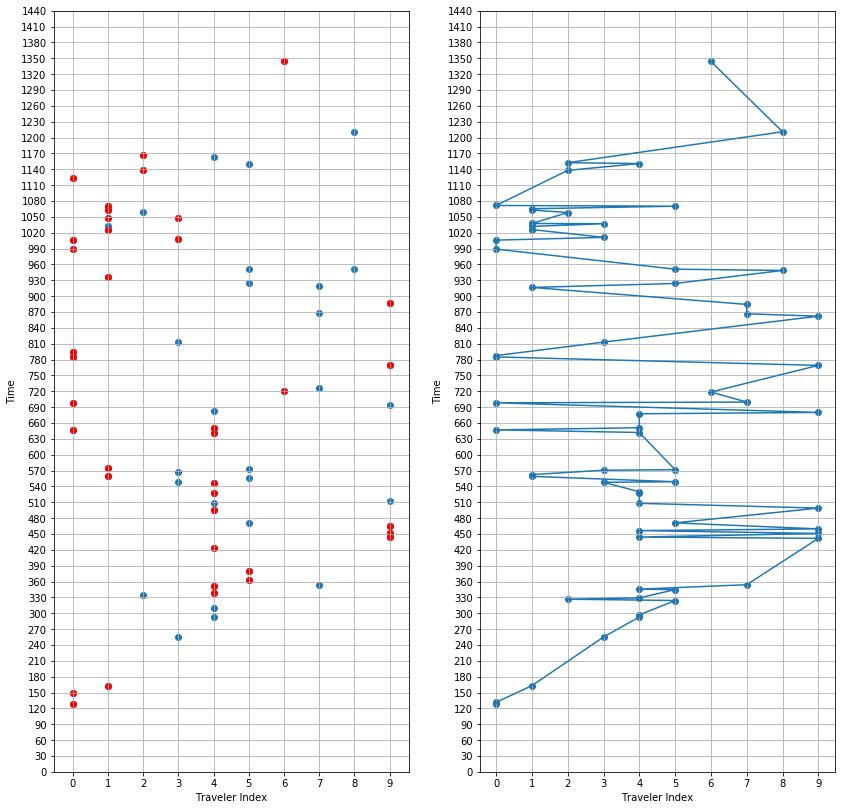

In [273]:
z=traveler_trips[traveler_trips.hh_id==2287301]
z.loc[:,'p_id']=z.groupby(['person_id']).ngroup()
z.loc[:,'expected_arrival']=z.starttime+z.travel_time
person_id_and_inhouse_p_id_map=dict(zip(z.person_id,z.p_id))
person_id_and_inhouse_p_id_map[0]=-1
sorted_trips.loc[:,'p_id']=sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
plt.pyplot.figure(1,figsize=[14,14])
plt.pyplot.subplot(121)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)

# plt.pyplot.scatter(z.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),z.starttime,marker='o',facecolors='none', edgecolors='r')

# plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
#                 route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'start_time']
#                )
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(122)
# plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
# plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
#                    sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
#                    c='r')

plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))

In [ ]:
print('start sovling problem at ',datetime.datetime.now())
output_flag=0
target_hh_id=3578994
num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,visit_candidate_zone=extract_hh_information(target_hh_id,traveler_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
R=[150]*(hh_num_trips+1)
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,early_penalty,late_penalty,R,output_flag)
route_info1=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
print('finish solving problem at ',datetime.datetime.now())

In [ ]:
route_info

In [ ]:
route_info1

##### Solve the problem for all households

In [117]:
route_infos=get_route_info_allhh(traveler_trips,0)

Estimate Route for the  0 th household  2018-03-06 15:20:51.182939
Estimate Route for the  100 th household  2018-03-06 15:27:45.101253
Estimate Route for the  200 th household  2018-03-06 15:40:04.541030
Estimate Route for the  300 th household  2018-03-06 16:03:09.357795
Estimate Route for the  400 th household  2018-03-06 16:25:22.770115
Estimate Route for the  500 th household  2018-03-06 16:35:06.631290
Estimate Route for the  600 th household  2018-03-06 16:46:16.836477
Estimate Route for the  700 th household  2018-03-06 17:03:29.136531
Estimate Route for the  800 th household  2018-03-06 17:11:51.560097
Estimate Route for the  900 th household  2018-03-06 17:20:56.963808
Estimate Route for the  1000 th household  2018-03-06 17:33:16.480898
Estimate Route for the  1100 th household  2018-03-06 17:40:31.276433
Estimate Route for the  1200 th household  2018-03-06 17:49:10.306086
Estimate Route for the  1300 th household  2018-03-06 17:57:41.210770
Estimate Route for the  1400 th 

Estimate Route for the  11700 th household  2018-03-07 11:31:10.975127
Estimate Route for the  11800 th household  2018-03-07 11:39:50.632980
Estimate Route for the  11900 th household  2018-03-07 11:43:09.745300
Estimate Route for the  12000 th household  2018-03-07 11:47:05.265462
Estimate Route for the  12100 th household  2018-03-07 11:52:48.080610
Estimate Route for the  12200 th household  2018-03-07 11:57:34.893993
Estimate Route for the  12300 th household  2018-03-07 12:03:45.645134
Estimate Route for the  12400 th household  2018-03-07 12:09:21.083668
Estimate Route for the  12500 th household  2018-03-07 12:13:41.943846
Estimate Route for the  12600 th household  2018-03-07 12:17:32.178930
Estimate Route for the  12700 th household  2018-03-07 12:21:57.570372
Estimate Route for the  12800 th household  2018-03-07 12:26:44.258756
Estimate Route for the  12900 th household  2018-03-07 12:32:42.525492
Estimate Route for the  13000 th household  2018-03-07 12:42:34.871058
Estima

Estimate Route for the  23300 th household  2018-03-07 22:25:00.106412
Estimate Route for the  23400 th household  2018-03-07 22:27:28.763120
Estimate Route for the  23500 th household  2018-03-07 22:29:31.169750
Estimate Route for the  23600 th household  2018-03-07 22:32:25.357790
Estimate Route for the  23700 th household  2018-03-07 22:34:31.530054
Estimate Route for the  23800 th household  2018-03-07 22:37:26.546213
Estimate Route for the  23900 th household  2018-03-07 22:39:26.921588
Estimate Route for the  24000 th household  2018-03-07 22:41:54.578286
Estimate Route for the  24100 th household  2018-03-07 22:44:42.000677
Estimate Route for the  24200 th household  2018-03-07 22:46:47.829189
Estimate Route for the  24300 th household  2018-03-07 22:49:02.345230
Estimate Route for the  24400 th household  2018-03-07 23:01:05.769331
Estimate Route for the  24500 th household  2018-03-07 23:03:51.988593
Estimate Route for the  24600 th household  2018-03-07 23:06:01.051491
Estima

In [118]:
route_infos.to_csv('Output/route_infos_fullconversion_lessthan40triphh.csv')

In [ ]:
route_infos.to_csv('Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_fullconversion.csv')
route_infos_part_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption.head()

#### Compare the new route with the old one

In [ ]:
initial_trips=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
len1=[]
len2=[]
origin_num_car_trips=[]
num_empty_car_trips=[]
num_initial_car_trips=0
for name, group in route_infos_full_adoption.groupby(['hh_id']):
    num_initial_car_trips=num_initial_car_trips+len(initial_trips.loc[(initial_trips.hh_id==name) & ((initial_trips.tripmode<=6) | (initial_trips.tripmode==13))])
#     len1.extend([len(group)])
#     len2.extend([len(initial_trips.loc[initial_trips.hh_id==name])])
#     origin_num_car_trips.extend([len(initial_trips.loc[(initial_trips.tripmode<=6) | (initial_trips.tripmode==13)])])
#     num_empty_car_trips.extend([len(group[group.person_id==0])])

In [ ]:
zz=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime']).groupby('hh_id').count() 

In [ ]:
zz1=traveler_trips.groupby('hh_id').count() 

In [ ]:
traveler_trips.columns

In [ ]:
zz[zz.person_id>30].person_id.sum()

In [ ]:
print('The new route plan has ',sum(len1),' trips')
print('The origin trip plan has ',sum(len2),' trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode<=6]),'car trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode==13]),'taxi trips')
print('The new route plan has',sum(num_empty_car_trips),'empty car trips')

### Route result analysis

##### Estimate how many trips are satisfied

In [ ]:
route_infos.head()

In [ ]:
def calculate_num_pick_up_trips(route_infos,traveler_trips):
    total_num_pickup_trip=0
    total_num_joint_trip=0
    for target_hh_id in route_infos.hh_id.unique():
        target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
        #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
        sorted_trips=target_hh.sort_values("starttime")
        hh_num_trips=len(sorted_trips)
        total_num_pickup_trip=total_num_pickup_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)])
        total_num_joint_trip=total_num_joint_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)& (route_infos.dest_node_index<hh_num_trips)])
    return total_num_pickup_trip,total_num_joint_trip
    #     print(target_hh_id)

In [ ]:
# Calculate the number of trips with/without passenger
full_adoption_num_pickup,full_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_full_adoption,traveler_trips)
full_adoption_empty_trips=len(route_infos_full_adoption.loc[route_infos_full_adoption.person_id==0])
partial_adoption_num_pickup,partial_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_part_adoption,traveler_trips)
partial_adoption_empty_trips=len(route_infos_part_adoption.loc[route_infos_part_adoption.person_id==0])

In [ ]:
full_adoption_num_pickup

In [ ]:
partial_adoption_num_pickup

In [ ]:
full_adoption_extra_joint

In [ ]:
len(route_infos_part_adoption)

In [ ]:
partial_adoption_extra_joint

In [ ]:
print('The full conversion plan pickup ',full_adoption_num_pickup,'trips (',round(full_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The full conversion plan incurs ', full_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is', full_adoption_empty_trips/full_adoption_num_pickup)
print('The partial conversion plan pickup ',partial_adoption_num_pickup,'trips (',round(partial_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The partial conversion plan incurs ', partial_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is' ,partial_adoption_empty_trips/partial_adoption_num_pickup)

In [ ]:
route_infos_full_adoption.columns

In [ ]:
z=route_infos_full_adoption.groupby('hh_id').apply(lambda x: (x==0).sum())

In [ ]:
z['num_hh_member']=traveler_trips.groupby('hh_id')['person_id'].nunique()

In [ ]:
def plot_num_trips_by_timeinterval(route_infos):
    route_infos['occupy_flag']=['Occupied' if x >0 else 'Empty' for x in route_infos['person_id']]
    route_infos['start_time_interval']=[math.floor(x/36) for x in route_infos['start_time']]
    z=route_infos.groupby(['start_time_interval', 'occupy_flag'])['start_time'].count().unstack('occupy_flag').fillna(0)
#     fig, axes = plt.pyplot.subplots(nrows=1 ,ncols=1,figsize=(16,6))
    
    z[['Occupied','Empty']].plot(kind='bar',stacked=True,figsize=(16,6))
    z['Empty_percentage']=z['Empty']/(z['Occupied']+z['Empty'])
#     z['Empty_percentage'].plot(kind='bar',ax=axes[1])
    return z

In [ ]:
z1=plot_num_trips_by_timeinterval(route_infos_full_adoption)

In [ ]:
z2=plot_num_trips_by_timeinterval(route_infos_part_adoption)

In [ ]:
fig = plt.pyplot.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
z1.Empty_percentage.plot(kind='bar',ax=ax,color='r',position=0)
z2.Empty_percentage.plot(kind='bar',ax=ax2,color='blue',position=1)

#### Write the route to DYNASMART input file vehicle.dat

In [ ]:
vehicledat_filepath='Output/vehicle_partconversion.dat'
path_filepath='Output/path_partconversion.dat'

In [ ]:
def read_vehicledat(vehicledat_filepath):
    '''
    This function read all sort of vehicledat file. It returns a dataframe vehicle_info that 
    contains all the information. Each row is corresponding to one vehicle in the vehicle.dat. 
    
    '''
    feature_list=['counter','iutmp','idtmp','StartTime','ivcltmp','ivcl2tmp','ihovtmp','veh_pathnodenum','NonrepetitiveCarNumTrip','infotmp','ribftmp','comptmp','TAZMap','value_of_time','value']
    i=0 #line number of vehicle.dat
    j=0 #line number of vehicle_info
    dest_chain=[]
    activity_chain=[]
    with open(vehicledat_filepath) as f: #Open the file
        for line in f:
            if i ==0: #Read the num_vehicle and max number of unit from the first line
                num_vehicle=int(line.split()[0])
                max_num_trips=int(line.split()[1])
                vehicle_info = pd.DataFrame(0,index=np.arange(num_vehicle), columns=feature_list)
            elif i >1:
                if (len(line)>30): #If the line is the first line of a vehicle, read the general information about vehicle
                    vehicle_info.iloc[j]=[float(k) for k in line.split()]
                    dest_chain.append([])
                    activity_chain.append([])
                    j=j+1
                else:
                    taz_temp,activity_time=line.split()
                    dest_chain[j-1].extend([taz_temp])
                    activity_chain[j-1].extend([activity_time])
                    
            i=i+1
        vehicle_info['dest_chain']=dest_chain
        vehicle_info['activity_time']=activity_chain
    return vehicle_info
def read_pathdat(pathdat_filepath):
    path_bank=[]
    with open(pathdat_filepath) as f:
        for line in f:
            path_bank.append([int(i) for i in line.split()])
    return path_bank

In [ ]:
def read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath):
    feature_list=['counter','iutmp','idtmp','StartTime','ivcltmp','ivcl2tmp','ihovtmp','veh_pathnodenum',
                  'NonrepetitiveCarNumTrip','infotmp','ribftmp','comptmp','TAZMap','value_of_time','value']
    i=0 #line number of vehicle.dat
    j=0 #line number of vehicle_info
    dest_chain=[]
    activity_chain=[]
    key=[]
    with open(intrasuperzone_vehicle_filepath) as f: #Open the file
        for line in f:
            if i ==0: #Read the num_vehicle and max number of unit from the first line
                num_vehicle=int(line.split()[0])
                max_num_trips=int(line.split()[1])
                vehicle_info = pd.DataFrame(0,index=np.arange(num_vehicle), columns=feature_list)
            elif i >1:
                if (len(line)>30): #If the line is the first line of a vehicle, read the general information about vehicle
                    vehicle_info.iloc[j]=[float(k) for k in line.split()]
                    
                    j=j+1
                else:
                    taz_temp,activity_time=line.split()
                    dest_chain.extend([taz_temp])
                    activity_chain.extend([activity_time])
                    key.append(tuple([int(vehicle_info.iloc[j-1]['TAZMap']),int(taz_temp)]))
            i=i+1
        print(dest_chain)
        vehicle_info['dest_chain']=dest_chain
        vehicle_info['activity_time']=activity_chain
        
    intrasuperzone_path=read_pathdat(intrasuperzone_path_filepath)
    intrasuperzone_info=vehicle_info
    intrasuperzone_info['path']=intrasuperzone_path
    intrasuperzone_path_dic=dict(zip(tuple(key),intrasuperzone_path))
    return intrasuperzone_info,intrasuperzone_path_dic

In [ ]:
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)

In [ ]:
Output_folder='Output/'
if not os.path.exists(Output_folder):
    os.makedirs(Output_folder)
vehicle_filepath=Output_folder+'vehicle_partconversion.dat'

In [ ]:
def route_to_vehiclepathdat(route_infos,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time):
    '''
    This function write all the route information in the format of vehicle.dat
    '''
    vehicledat=open(vehicle_filepath,'w')
    pathdat=open(path_filepath,'w')
    if os.path.isfile(external_vehicle_filepath):
        external_vehicle=open(external_vehicle_filepath,'r')
        num_external_vehicle=int(next(external_vehicle).split()[0])
        next(external_vehicle)
        excounter,exusec,exdsec,exstime,exusrcls,exvehtype,exioc,exonode,exintde,exinfo,exribf,excomp,exoz=next(external_vehicle).split()
        exTAZMap,exactivitytime=next(external_vehicle).split()
        exstime=float(exstime)+180 #External vehicle start from 0:00am but the abm file start from 3 am
    else:
        exstime=1555
    
    num_veh_seg=len(route_infos['veh_seg_index'].unique())
    max_num_trip=route_infos.groupby('veh_seg_index')['start_time'].count().max()
    total_veh_seg=num_veh_seg+num_external_vehicle
    vehicledat.write(str(total_veh_seg)+'\t'+str(max_num_trip)+'\t'+'# of vehicles in the file, Max # of stops\n')
    vehicledat.write('counter  iutmp  idtmp  StartTime  ivcltmp  ivcl2tmp  ihovtmp  veh_pathnodenum  NonrepetitiveCarNumTrip  infotmp  ribftmp  comptmp  TAZMap  value_of_time  1\n')
    counter=1
    multiindex_route_infos=route_infos.set_index(['veh_seg_index'])
    for veh_seg in route_infos.sort_values('origin_arrival_time')['veh_seg_index'].unique():
        target_seg=multiindex_route_infos.loc[[veh_seg]]
        
        while target_seg.origin_arrival_time.min()>exstime:
            vehicledat.write(str(counter)+'\t'+exusec+'\t'+exdsec+'\t'+str(exstime)+'\t'+
                             exusrcls+'\t'+exvehtype+'\t'+exioc+'\t'+
                             '1'+'\t'+exintde+'\t'+exinfo+'\t'+exribf+'\t'+excomp+'\t'+
                             exoz+'\t'+str(average_value_of_time)+'\t'+'1'+'\n')
            vehicledat.write(exTAZMap+'\t'+exactivitytime+'\n')
            pathdat.write('\n')
            counter +=1
            line_listtemp=next(external_vehicle).split()
            if len(line_listtemp)>3:
                excounter,exusec,exdsec,exstime,exusrcls,exvehtype,exioc,exonode,exintde,exinfo,exribf,excomp,exoz=line_listtemp
                exTAZMap,exactivitytime=next(external_vehicle).split()
                exstime=float(exstime)+180 #External vehicle start from 0:00am but the abm file start from 3 am
            else: 
                exstime=1555
        if counter==23300:
            print(veh_seg,exstime,target_seg.start_time.min(),target_seg)
        write_one_veh_seq(target_seg,vehicledat,pathdat,counter,origin_links,superzone_map,intrasuperzone_path_dic)
        counter +=1
        if counter%1000==0: 
            print(counter,datetime.datetime.now())
    vehicledat.close()
    pathdat.close()
    return
def write_one_veh_seq(route_info,file_obj,path_file_obj,counter,origin_links,superzone_map,intrasuperzone_path_dic):
    '''
    This function convert the route information of one segment into vehicle.dat format. The function is called by route_to_vehiclepathdat
    '''
    ivcl2tmp=1        #Standard Input for Vehicle Specifications 
    ihovtmp=1         #Standard Input for Vehicle Specifications  
    veh_pathnodenum=1 #Standard Input for Vehicle Specifications
    ndestmp=1         #Standard Input for Vehicle Specifications
    infotmp=0         #Standard Input for Vehicle Specifications 
    ribftmp=0.0       #Standard Input for Vehicle Specifications  
    comptmp=0.0       #Standard Input for Vehicle Specifications  
    if (route_info.iloc[0].intrasuperzone_flag==1):
        path_temp=intrasuperzone_path_dic[(route_info.iloc[0]['orig_zone'],route_info.iloc[0]['dest_zone'])]
        orig_u_node,orig_d_node=path_temp[0:2]
        ivcltmp=1
        veh_pathnodenum=len(path_temp)
        path_file_obj.write(''.join( str(j).rjust(7) for j in intrasuperzone_path_dic[(route_info.iloc[0]['orig_zone'],route_info.iloc[0]['dest_zone'])])+'\n')
    else:
        target_zone=origin_links.loc[origin_links.zone_id==route_info.iloc[0]['orig_zone']]
        generateion_link_index=np.random.randint(0,len(target_zone))
        orig_u_node= target_zone.iloc[generateion_link_index]['u_node'] #Upstream node of the generation link 
        orig_d_node= target_zone.iloc[generateion_link_index]['d_node'] #Downstream node of the generation link
        ivcltmp=3
        veh_pathnodenum=1
        path_file_obj.write('\n')
    
    file_obj.write(str(counter)+'\t'+str(int(orig_u_node))+'\t'
                   +str(int(orig_d_node))+'\t'+str(round(route_info.iloc[0]['origin_arrival_time'],1))+'\t'
                   +str(ivcltmp)+'\t'+str(ivcl2tmp)+'\t'+str(ihovtmp)+'\t'+str(veh_pathnodenum)+'\t'
                   +str(len(route_info))+'\t'+str(infotmp)+'\t'+str(ribftmp)+'\t'
                   +str(comptmp)+'\t'+ str(route_info.iloc[0]['orig_zone'])+'\t'
                   +str(route_info.iloc[0]['value_of_time'])+'\t'+'1'+'\n')
    for (index,row) in route_info.iloc[:-1].iterrows():
        file_obj.write(str(row['dest_zone'])+'\t'+str(row['Activity_Time'])+'\n')
    file_obj.write(str(route_info['dest_zone'].iloc[-1])+'\t'+'0.0\n')
    if (route_info.dest_zone.iloc[-1]<1):
        print('error')
    return

In [ ]:
route_infos[route_infos.hh_id==869256]

In [ ]:
vehicledat_filepath='Output/vehicle_partconversion.dat'
path_filepath='Output/path_partconversion.dat'
external_vehicle_filepath='Input/external_vehicle.dat'
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
route_to_vehiclepathdat(route_infos,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
# new_path='Output/newpath.dat'
# path_fileobj=open(new_path,'w')
# with open('Output/path.dat') as f:
#     for line in f: 
#         if len(line)>1:
#             for node in line.split():
#                 path_fileobj.write(node.rjust(7))
#             path_fileobj.write('\n')
#         else: 
#             path_fileobj.write('\n')
# path_fileobj.close()

#### Result Analysis